In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 2. Single particle tracking



## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

import datasets
datasets.load('ParticleSizing')
experimental_data = np.load('datasets/ParticleSizing/sizing_150nm_227nm_PSL.npy', allow_pickle=True)

import scipy.io as IO

IMAGE_SIZE = 64

ParticleSizing already downloaded! Use force_overwrite=True to redownload the dataset.


## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 64 by 64 pixel images, containing a single particle each. The particles are simulated as spheres with a radius between 100nm and 400nm, and a refractive index between 1.37 and 1.67. Its position in the camera plane is constrained to be within within two pixels of the image center, and is sampled with a normal distribution with standard deviation of 2 pixel units along the axis normal to the camera plane. 

In [3]:
particle = dt.MieParticle(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 2,
    radius=lambda:1e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.rand() * 0.3 + 1.37,
    L=8,
    position_unit="pixel",
)

We use a single wavelengtj brightifeld feature to calculate the field at the camera plane. We aberrate the image with a random coma, which was observed in the experimental data. Moreover, the pupil is cropped at high frequencies.

In [4]:
HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=23)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=635e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil= HC + VC + CROP
)

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. The amplitude of the noise is determined by the dummy property `level`, which is explicitly shared between the two features. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [5]:
real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda level: level * 0.03, 
    level=lambda: np.random.rand() * 0.8
)

noise = real_noise + dt.Gaussian(mu=0, sigma=lambda: real_noise.level * 0.03j)

def func():
    def inner(image):
        image = -(image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func)

We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [6]:
dataset = optics(particle + noise) + complex_to_float

### 2.2 Defining the training label

We extract the parameters we want the network to learn. We also rescale them such that they have a similar size.

In [7]:
def get_label(image):
    px = np.array(image.get_property("position")) - IMAGE_SIZE / 2
    z = image.get_property("z") * 0.1
    r = image.get_property("radius") / 1e-6
    n = image.get_property("refractive_index") - 1.33
    return np.array([r * 10, n * 10])

# 2.3 Visualizing the dataset

We resolve and show 16 images

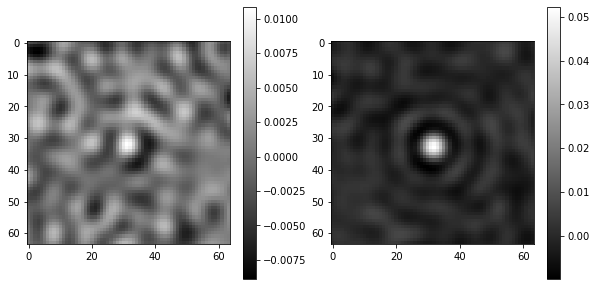

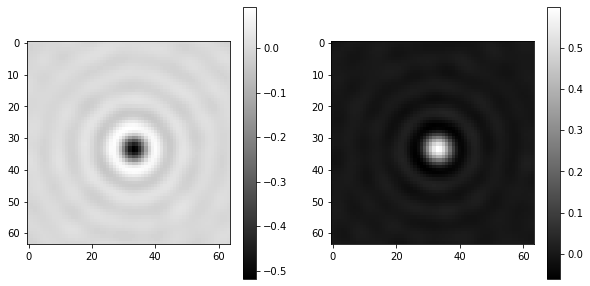

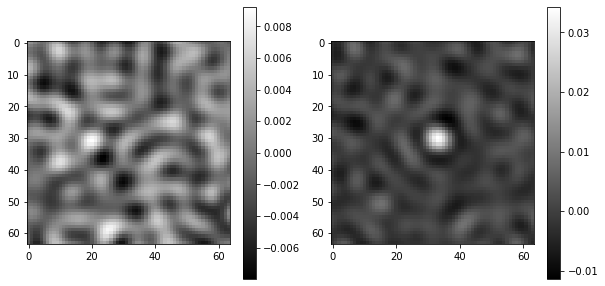

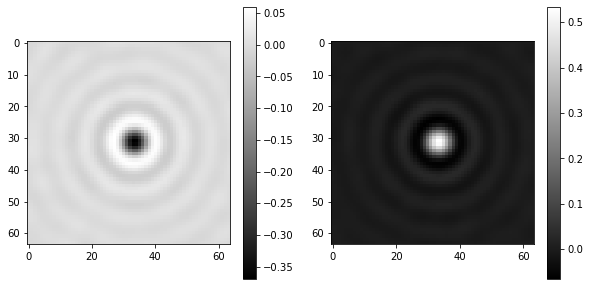

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\bmidt\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-3870c2a4b39c>", line 11, in <module>
    plt.colorbar()
  File "c:\users\bmidt\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py", line 2177, in colorbar
    ret = gcf().colorbar(mappable, cax=cax, ax=ax, **kw)
  File "c:\users\bmidt\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py", line 2335, in colorbar
    cax, kw = cbar.make_axes_gridspec(ax, **kw)
  File "c:\users\bmidt\appdata\local\programs\python\python37\lib\site-packages\matplotlib\colorbar.py", line 1631, in make_axes_gridspec
    cax = fig.add_subplot(gs2[1], label="<colorbar>")
  File "c:\users\bmidt\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py", line 1402, in add_subplot
    ax = subpl


KeyboardInterrupt



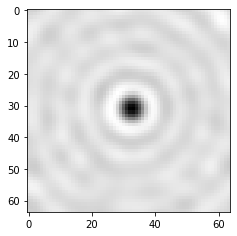

In [8]:
## NUMBER_OF_IMAGES = 16

for i in range(16):
    dataset.update()
    image_of_particle = dataset.resolve()

    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image_of_particle[:, :, 0], cmap="gray")
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.imshow(image_of_particle[:, :, 1], cmap="gray")
    plt.colorbar()
    plt.show()


## 3. Defining the network

The network used is a Convolutional network, with a the pixel error as loss.

In [9]:
import keras.backend as K
import keras.optimizers as optimizers

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    conv_layers_dimensions=(32, 64, 128),
    dense_layers_dimensions=(64, 64),
    steps_per_pooling=2,
    number_of_outputs=5,
    dropout=(.2, .2),
    loss="mae",
    optimizer="adam"
)


## 4. Training the network

We use the `ContinuousGenerator` to generate the images. It creates a new therad and generates images while the model is training. 

Set TRAIN_MODEL to True to train the model, otherwise a pretrained model is downloaded.

In [12]:
TRAIN_MODEL = False

from tensorflow.keras.callbacks import EarlyStopping

validation_set_size = 256
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset,
        get_label,
        min_data_size=int(2e3),
        max_data_size=int(2e4),
        batch_size=64
    )

    with generator:
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            epochs=100,
        )
else:
    model_path = datasets.load_model("ParticleSizing")
    model.load_weights(model_path)

ParticleSizing already downloaded! Use force_overwrite=True to redownload the model.


## 5. Evaluating the network

We show the the error as a function of some properties.

In [ ]:
plt.plot(h.history["val_loss"])

In [ ]:
properties = ["radius", "refractive_index", "sigma"]

validation_prediction = model.predict(np.array(validation_set))

validation_errors = [
    np.abs(validation_prediction[:, idx] - np.array(validation_labels)[:, idx]) for idx in range(2)
]

error_names = ["radius", "refractive index"]

for property_name in properties:
    property_values = np.array([image.get_property(property_name) for image in validation_set])
    if property_values.ndim == 1:
        property_values = np.expand_dims(property_values, axis=-1)
    
    for col in range(property_values.shape[1]):
        values = property_values[:, col]

        plt.subplot(1, property_values.shape[1], col + 1)
        for validation_error in validation_errors:
            plt.scatter(values, validation_error, alpha=1)
        plt.xlim([np.min(values), np.max(values)])
        plt.ylim([np.min(validation_error), np.max(validation_error)])
        plt.yscale("log")
        plt.ylabel("Absolute error")
        plt.xlabel("{0}[{1}]".format(property_name, col))
        
    plt.legend(error_names)

    
    plt.show()

We estimate the size of particles using experimentally captured images. The particles were traced, so we display the average size and refractive index measured by the model over the trace.

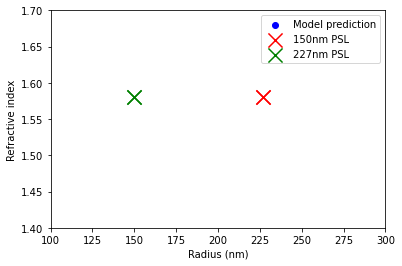

In [14]:
predictions = np.array([
        np.mean(
            model.predict(
                np.array(experimental_data[idx])
            ),
            axis=0
        ) for idx in range(len(experimental_data))
])

plt.scatter([],[], c='b', alpha=1)
# plt.scatter(predictions[:, 3] * 100, predictions[:, 4] / 10 + 1.33, c='b', alpha=0.1)
plt.scatter(0.227 * 1000, 1.58, marker='x', s=200, c='r')
plt.scatter(0.15 * 1000, 1.58, marker='x', s=200, c='g')

plt.scatter(predictions[:, 0] * 100, predictions[:, 1] / 10 + 1.33, c='m', alpha=0.1)
plt.scatter(0.227 * 1000, 1.58, marker='x', s=200, c='r')
plt.scatter(0.15 * 1000, 1.58, marker='x', s=200, c='g')
plt.legend(["Model prediction", "150nm PSL", "227nm PSL"])
plt.axis([100, 300, 1.4, 1.7])
plt.xlabel('Radius (nm)')
plt.ylabel('Refractive index')
plt.show()

In [16]:
import scipy.io
scipy.io.savemat('../../figures/sizing.mat', {
    "data":experimental_data,
    "validation":validation_set,
    "predictions": predictions[:, 3:],
})